## Импортирую необходимые библиотеки

In [ ]:
#!pip install -q xlrd  # пакет для чтения excel-файлов
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
pd.set_option('max_columns', 50)  # отображать 50 колонок максимум
pd.set_option('max_rows', 25)  # отображать 25 строк максимум
# pd.set_option('display.max_colwidth', None)  # отображать весь текст в ячейках

Загрузка файла данных с диска

In [ ]:
!gdown 1WhPlHp-aW0QHlHXUag2Hm7A8XzOkr5Ac

Downloading...
From: https://drive.google.com/uc?id=1WhPlHp-aW0QHlHXUag2Hm7A8XzOkr5Ac
To: /content/data26.xlsx
100% 84.4M/84.4M [00:00<00:00, 155MB/s]


## 1. Создаю DataFrame, изучаю его

In [ ]:
df = pd.read_excel('data26.xlsx')

In [ ]:
df.shape

(69656, 34)

In [ ]:
df = df.drop_duplicates(['name', 'employer', 'department', 'area'])  # удаляю дубликаты с учтётом значений в 4-х колонках

In [ ]:
df.shape

(68265, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68265 entries, 0 to 69655
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                68265 non-null  int64  
 1   id                        68265 non-null  int64  
 2   premium                   68265 non-null  bool   
 3   name                      68265 non-null  object 
 4   department                5083 non-null   object 
 5   has_test                  68265 non-null  bool   
 6   response_letter_required  68265 non-null  bool   
 7   area                      68265 non-null  object 
 8   salary                    36724 non-null  object 
 9   type                      68265 non-null  object 
 10  address                   39434 non-null  object 
 11  response_url              1 non-null      object 
 12  sort_point_distance       0 non-null      float64
 13  published_at              68265 non-null  object 
 14  create

In [ ]:
df.describe()  # по умолчанию никакой полезной информации в статистиках

,Unnamed: 0,id,sort_point_distance
count,68265.000000,6.826500e+04,0.0
mean,3761.696829,5.464607e+07,NaN
std,5239.911472,4.018582e+06,NaN
min,0.000000,6.555939e+06,NaN
25%,306.000000,5.444951e+07,NaN
50%,1141.000000,5.519356e+07,NaN
75%,5388.000000,5.547258e+07,NaN
max,20065.000000,6.611540e+07,NaN


In [ ]:
# df.drop(['Unnamed: 0'], axis=1, inplace=True)  # можно удалить первую колонку, чтобы использовать внутренние индексы

## 2. Привожу колонку salary к числовому виду

In [ ]:
df['salary'].describe()

count                                                 36724
unique                                                 4073
top       {'from': 50000, 'to': None, 'currency': 'RUR',...
freq                                                   1135
Name: salary, dtype: object

In [ ]:
df['salary'].iloc[1]  # вывожу полную строку из колонки salary для написания функции обработки

"{'from': 25000, 'to': 50000, 'currency': 'RUR', 'gross': True}"

Функция, которая возвращает среднее значение между от и до с учётом валюты и налога 13%, если одно из значений не указано, то берется крайнее, если значений нет, то возвращает 0.

In [ ]:
def salary_edit(string):
    if not string:
        return 0
    try:
      val = json.loads(
          str(string).replace('False', '"False"').replace('True', '"True"').replace("'", '"').replace('None', 'null'))
      
      frm, to, gross, currency = val['from'], val['to'], val['gross'], val['currency']
      exchange = 56.7 if currency == 'USD' else 59.1 if currency == 'EUR' else 1

      if frm is None and to is None:
          return 0
      elif frm is None and to is not None:
          return int(((to / 1.13) if gross == 'True' else to) * exchange)
      elif frm is not None and to is None:
          return int(((frm / 1.13) if gross == 'True' else frm) * exchange)
      else:
          return int(round(((frm + to) / 1.13) / 2 if gross == 'True' else (frm + to) / 2) * exchange)
    except:
      # return 0
      pass
      

In [ ]:
df['salary'] = df['salary'].apply(salary_edit)

После обработки по категориям можно нулевые значения заменить на средние по категориям:

    mean = df.groupby(somewhat_category)['column'].mean()
    df.fillna(mean)

In [ ]:
df.head()

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url
0,0,49059633,False,Младший специалист ручного тестирования,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-05-23T09:11:18+0300,2022-05-23T09:11:18+0300,False,NaN,https://api.hh.ru/vacancies/49059633?host=hh.ru,https://hh.ru/vacancy/49059633,[],"{'id': '1740', 'name': 'Яндекс', 'url': 'https...",{'requirement': 'Внимательны и наблюдательны. ...,NaN,"{'id': 'remote', 'name': 'Удаленная работа'}",[],[],[],False,<p>В некоторых проектах Яндексу помогают компа...,"{'id': 'noExperience', 'name': 'Нет опыта'}",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Астраханская область,NaN
1,1,54653519,False,Тестировщик.Net,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",33186.0,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-04-28T17:36:03+0300,2022-04-28T17:36:03+0300,False,NaN,https://api.hh.ru/vacancies/54653519?host=hh.ru,https://hh.ru/vacancy/54653519,[],"{'id': '1245158', 'name': 'МФК Саммит', 'url':...",{'requirement': 'Мы ищем талантливого и амбици...,"{'name': 'Синанова Мария', 'email': 'sinanova....","{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<p><em><strong>Мы ищем талантливого и амбициоз...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN
2,2,55116066,False,Пентестер,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-05-20T10:07:33+0300,2022-05-20T10:07:33+0300,False,NaN,https://api.hh.ru/vacancies/55116066?host=hh.ru,https://hh.ru/vacancy/55116066,[],"{'id': '719820', 'name': 'SearchInform', 'url'...",{'requirement': 'Глубокие знания клиентских и ...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<p>Лидер на рынке систем информационной безопа...,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN
3,3,54031261,False,Ведущий Специалист по информационным технологиям,"{'id': 'pochta-4352-office', 'name': '«Почта Р...",False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",23008.0,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Астрахань', 'street': 'улица Черныше...",NaN,NaN,2022-05-23T07:46:16+0300,2022-05-23T07:46:16+0300,False,NaN,https://api.hh.ru/vacancies/54031261?host=hh.ru,https://hh.ru/vacancy/54031261,[],"{'id': '4352', 'name': 'Почта России', 'url': ...",{'requirement': 'Средне-профессиональное или в...,"{'name': 'Данилова Екатерина Александровна', '...","{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<ul> <li>Администрирование компьютерной сети</...,"{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Пользователь ПК'}, {'name': 'Работа...","[{'id': '1.110', 'name': 'Компьютерная безопас...",Астраханская область,NaN
4,4,55243040,False,Специалист по защите информации,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",20000.0,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Астрахань', 'street': 'улица Молодой...",NaN,NaN,2022-05-06T10:18:54+0300,2022-05-06T10:18:54+0300,False,NaN,https://api.hh.ru/vacancies/55243040?host=hh.ru,https://hh.ru/vacancy/55243040,[],"{'id': '6694236', 'name': 'ГБПОУ АО Астраханск...","{'requirement': 'Медицинская комиссия, справка...","{'name': 'Трубицына Елена', 'email': 'info@ast...","{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<strong>Обязанности:</strong> <ul> <li>Обеспеч...,"{'id': '

## 3. Обработка данных в колонках

Выделяю специализации из колонки **_specializations_**

In [ ]:
def profarea(string):

  res = []
  data = json.loads(string.replace("'", '"'))
  # print(data)
  for element in data:
    for k,v in element.items():
      if k == 'profarea_name':
        res.append(v)
  return(str(set(res)))


In [ ]:
df['specializations_edited'] = df['specializations'].apply(profarea)

In [ ]:
df['specializations_edited'].describe()

count                                                68265
unique                                                 254
top       {'Информационные технологии, интернет, телеком'}
freq                                                 36908
Name: specializations_edited, dtype: object

In [ ]:
df['specializations_edited'].value_counts().head(20)

{'Информационные технологии, интернет, телеком'}                                                                    36908
{'Управление персоналом, тренинги'}                                                                                  8337
{'Продажи', 'Информационные технологии, интернет, телеком', 'Консультирование', 'Маркетинг, реклама, PR'}            5586
{'Продажи', 'Консультирование', 'Строительство, недвижимость'}                                                       5316
{'Информационные технологии, интернет, телеком', 'Искусство, развлечения, масс-медиа', 'Маркетинг, реклама, PR'}     2598
{'Информационные технологии, интернет, телеком', 'Консультирование'}                                                 1786
{'Информационные технологии, интернет, телеком', 'Маркетинг, реклама, PR'}                                           1603
{'Маркетинг, реклама, PR'}                                                                                           1603
{'Спортивные клубы, фитн

Функция для выбора только специализации ИТ:

In [ ]:
def it_in_list(data):
  return 'Информационные технологии, интернет, телеком' in data

In [ ]:
filter = df['specializations_edited'].apply(it_in_list)
filter.describe()

count     68265
unique        2
top        True
freq      49679
Name: specializations_edited, dtype: object

In [ ]:
filter.value_counts()

True     49679
False    18586
Name: specializations_edited, dtype: int64

Применив фильтр, я удалил 18586 вакансий, не связаных с ИТ.

In [ ]:
df = df[filter]

In [ ]:
df.describe()

,Unnamed: 0,id,salary,sort_point_distance
count,49679.000000,4.967900e+04,22478.000000,0.0
mean,3979.682401,5.468925e+07,93861.796779,NaN
std,5280.225548,3.767057e+06,74738.050240,NaN
min,0.000000,6.555939e+06,30.000000,NaN
25%,384.000000,5.440801e+07,40500.000000,NaN
50%,1379.000000,5.517681e+07,70000.000000,NaN
75%,6303.500000,5.546657e+07,123893.000000,NaN
max,20065.000000,6.611540e+07,898230.000000,NaN


Можно оценить статистики по зарплате по всей ИТ (исключая минимальное значение, которое принимается как выброс и в дальнейшем будет скорректировно)

## 4. Выбираю колонки для анализа


In [ ]:
df.head()

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url,specializations_edited
0,0,49059633,False,Младший специалист ручного тестирования,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-05-23T09:11:18+0300,2022-05-23T09:11:18+0300,False,NaN,https://api.hh.ru/vacancies/49059633?host=hh.ru,https://hh.ru/vacancy/49059633,[],"{'id': '1740', 'name': 'Яндекс', 'url': 'https...",{'requirement': 'Внимательны и наблюдательны. ...,NaN,"{'id': 'remote', 'name': 'Удаленная работа'}",[],[],[],False,<p>В некоторых проектах Яндексу помогают компа...,"{'id': 'noExperience', 'name': 'Нет опыта'}",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Астраханская область,NaN,"{'Начало карьеры, студенты', 'Информационные т..."
1,1,54653519,False,Тестировщик.Net,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",33186.0,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-04-28T17:36:03+0300,2022-04-28T17:36:03+0300,False,NaN,https://api.hh.ru/vacancies/54653519?host=hh.ru,https://hh.ru/vacancy/54653519,[],"{'id': '1245158', 'name': 'МФК Саммит', 'url':...",{'requirement': 'Мы ищем талантливого и амбици...,"{'name': 'Синанова Мария', 'email': 'sinanova....","{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<p><em><strong>Мы ищем талантливого и амбициоз...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN,"{'Информационные технологии, интернет, телеком'}"
2,2,55116066,False,Пентестер,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,2022-05-20T10:07:33+0300,2022-05-20T10:07:33+0300,False,NaN,https://api.hh.ru/vacancies/55116066?host=hh.ru,https://hh.ru/vacancy/55116066,[],"{'id': '719820', 'name': 'SearchInform', 'url'...",{'requirement': 'Глубокие знания клиентских и ...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<p>Лидер на рынке систем информационной безопа...,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN,"{'Информационные технологии, интернет, телеком'}"
3,3,54031261,False,Ведущий Специалист по информационным технологиям,"{'id': 'pochta-4352-office', 'name': '«Почта Р...",False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",23008.0,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Астрахань', 'street': 'улица Черныше...",NaN,NaN,2022-05-23T07:46:16+0300,2022-05-23T07:46:16+0300,False,NaN,https://api.hh.ru/vacancies/54031261?host=hh.ru,https://hh.ru/vacancy/54031261,[],"{'id': '4352', 'name': 'Почта России', 'url': ...",{'requirement': 'Средне-профессиональное или в...,"{'name': 'Данилова Екатерина Александровна', '...","{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,<ul> <li>Администрирование компьютерной сети</...,"{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Пользователь ПК'}, {'name': 'Работа...","[{'id': '1.110', 'name': 'Компьютерная безопас...",Астраханская область,NaN,"{'Информационные технологии, интернет, телеком'}"
4,4,55243040,False,Специалист по защите информации,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",20000.0,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Астрахань', 'street': 'улица Молодой...",NaN,NaN,2022-05-06T10:18:54+0300,2022-05-06T10:18:54+0300,False,NaN,https://api.hh.ru/vacancies/55243040?host=hh.ru,https://hh.ru/vacancy/55243040,[],"{'id': '6694236', 'name': 'ГБПОУ АО Астрахан

### Заметки по колонкам:
 - id - для быстрой ссылки на вакансию в основном df
 - name - наименование професии (привести к удобоваримому виду)
 - salary - средний доход по специальностям
 - published_at - проанализировать, как долго размещено объявление
 - employer - найти топ работодателей, понять, есть ли у них свои программы подготовки
 - experience - какой уровень опыта наиболее востребован
 - key_skills - чсто требуется, чему учить

 ~~- specializations - предметная область~~ изначально отфильтровано по данному полю
 - region - интересно посмотреть, где больше всего вакансий, кроме Мск.



In [ ]:
df = df[['id', 'name', 'salary', 'published_at', 'employer', 'experience', 'key_skills', 'region']]

In [ ]:
df

,id,name,salary,published_at,employer,experience,key_skills,region
0,49059633,Младший специалист ручного тестирования,NaN,2022-05-23T09:11:18+0300,"{'id': '1740', 'name': 'Яндекс', 'url': 'https...","{'id': 'noExperience', 'name': 'Нет опыта'}",[],Астраханская область
1,54653519,Тестировщик.Net,33186.0,2022-04-28T17:36:03+0300,"{'id': '1245158', 'name': 'МФК Саммит', 'url':...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...",Астраханская область
2,55116066,Пентестер,NaN,2022-05-20T10:07:33+0300,"{'id': '719820', 'name': 'SearchInform', 'url'...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...",Астраханская область
3,54031261,Ведущий Специалист по информационным технологиям,23008.0,2022-05-23T07:46:16+0300,"{'id': '4352', 'name': 'Почта России', 'url': ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Пользователь ПК'}, {'name': 'Работа...",Астраханская область
4,55243040,Специалист по защите информации,20000.0,2022-05-06T10:18:54+0300,"{'id': '6694236', 'name': 'ГБПОУ АО Астраханск...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'MS Dos'}, {'name': 'Диагностика ПК'...",Астраханская область
...,...,...,...,...,...,...,...,...
69651,66113834,Программист Java,NaN,2022-05-26T14:40:09+0300,"{'id': '47858', 'name': 'Центральный банк Росс...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}",[],Тульская область
69652,66113885,Программист 1C,130000.0,2022-05-26T14:41:55+0300,"{'id': '97966', 'name': 'Окраина', 'url': 'htt...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С: Управление Торговлей'}, {'name'...",Тульская область
69653,54749225,Начальник отдела информационных технологий,50000.0,2022-05-23T09:22:06+0300,"{'id': '4494454', 'name': 'ГУЗ ГБ № 3 Г.Тулы',...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Организаторские навыки'}, {'name': ...",Тульская область
69654,55498724,"Технический директор (DevOps, технолог)",85000.0,2022-05-18T09:38:54+0300,"{'id': '180706', 'name': 'ИнтерЛабс', 'url': '...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}",[],Тульская область


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49679 entries, 0 to 69655
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            49679 non-null  int64  
 1   name          49679 non-null  object 
 2   salary        22478 non-null  float64
 3   published_at  49679 non-null  object 
 4   employer      49679 non-null  object 
 5   experience    49679 non-null  object 
 6   key_skills    49679 non-null  object 
 7   region        49679 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.4+ MB


In [ ]:
df.shape

(49679, 8)

##5. Числовые данные

In [ ]:
df['salary'].describe()


count     22478.000000
mean      93861.796779
std       74738.050240
min          30.000000
25%       40500.000000
50%       70000.000000
75%      123893.000000
max      898230.000000
Name: salary, dtype: float64

In [ ]:
df['salary'].median().astype(int)  # 50% perсentile

70000

In [ ]:
df['salary'].quantile(0.01)  # всё, что ниже, можно отбросить при анализе

11504.0

In [ ]:
df['salary'].quantile(0.99)  # всё, что выше, можно отбросить при анализе

350000.0

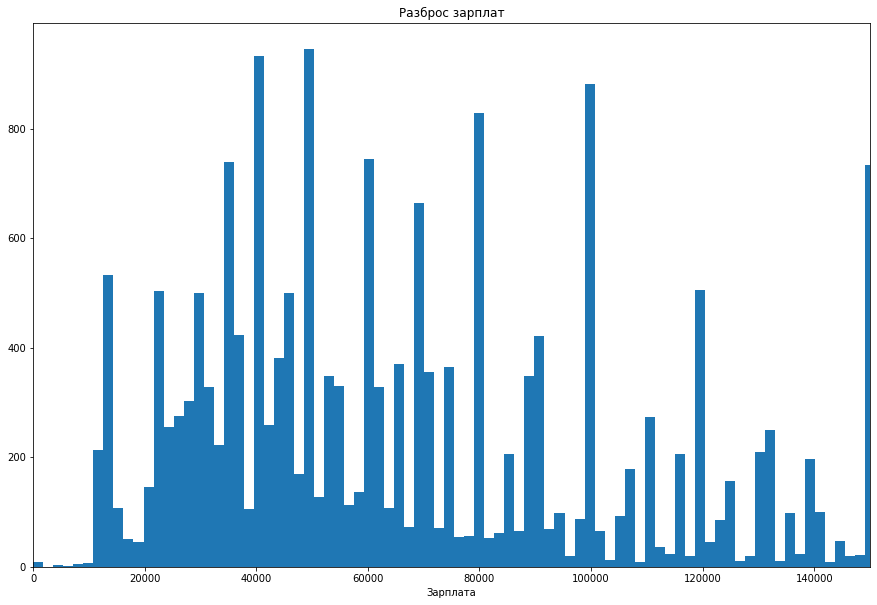

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Разброс зарплат')
plt.hist(df['salary'].dropna(), bins=500)
plt.xlim((0, 150_000))
plt.xlabel('Зарплата')
plt.show()


##6. Категориальные данные

In [ ]:
df['name'].describe()  # todo продумать, как привести вакансии к меньшему количеству уникальных значений

count                       49679
unique                      24007
top       Системный администратор
freq                         1625
Name: name, dtype: object

In [ ]:
df['name'].values

array(['Младший специалист ручного тестирования', 'Тестировщик.Net',
       'Пентестер', ..., 'Начальник отдела информационных технологий',
       'Технический директор (DevOps, технолог)',
       'Начальник отдела по защите информации и информационной безопасности'],
      dtype=object)

In [ ]:
df.loc[df['name'] == 'Программист 1С', 'name'] = 'Программист 1C'  # меняю значение 1С на английскую букву

In [ ]:
job_title = df['name'].value_counts()

In [ ]:
job_title.head(25)

Системный администратор                                       1625
Программист 1C                                                1428
Специалист технической поддержки                               471
Системный аналитик                                             433
Аналитик                                                       335
Инженер-программист                                            319
Графический дизайнер                                           309
Инженер технической поддержки                                  268
Бизнес-аналитик                                                262
Дизайнер                                                       251
Технический писатель                                           210
Руководитель проекта                                           204
Специалист по информационной безопасности                      181
Программист                                                    181
Frontend-разработчик                                          

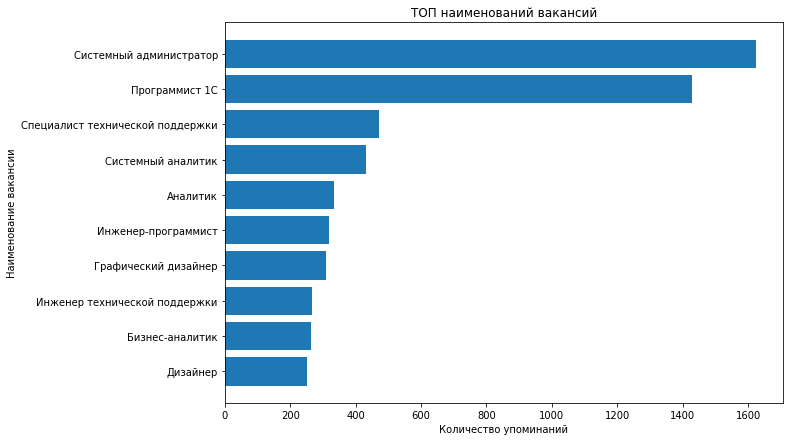

In [ ]:
job_title[:10].index
plt.figure(figsize=(10,7))
plt.barh(job_title[:10].index, job_title[:10].values)
plt.title('ТОП наименований вакансий')
plt.xlabel('Количество упоминаний')
plt.ylabel('Наименование вакансии')
plt.gca().invert_yaxis()  # инвертирую для отображения максимальных позиций вверху
plt.show()

In [ ]:
# TODO полумать, как выбрать топ-10 вакансий
# def job_name(data):
#   system_administrator = ['Системный администратор', 'сисадмин', 'DevOps']
#   1c_programmer = ['Программист 1С', 'Программист 1C']
#   analyst = ['Системный аналитик', 'Аналитик', 'Бизнес-аналитик']

In [ ]:
df['employer'].describe()

count                                                 49679
unique                                                13403
top       {'id': '1740', 'name': 'Яндекс', 'url': 'https...
freq                                                   1877
Name: employer, dtype: object

Выбираем ТОП работодателей:

In [ ]:
df['employer'][0]

"{'id': '1740', 'name': 'Яндекс', 'url': 'https://api.hh.ru/employers/1740', 'alternate_url': 'https://hh.ru/employer/1740', 'logo_urls': {'90': 'https://hhcdn.ru/employer-logo/3790847.png', '240': 'https://hhcdn.ru/employer-logo/3790848.png', 'original': 'https://hhcdn.ru/employer-logo-original/837491.png'}, 'vacancies_url': 'https://api.hh.ru/vacancies?employer_id=1740', 'trusted': True}"

In [ ]:
# не получается применить json.load() из-за неверных данных в каких-то строках, eval использую в следующей функции

def employer(string):
  try:
    return string.split(':')[2].split("'")[1]
  except:
    pass


In [ ]:
top_employer = df['employer'].apply(employer)

In [ ]:
top_employer.value_counts().head(15)

Яндекс                      1877
Газпром нефть                523
Сбербанк                     462
Тинькофф                     444
Ростелеком                   415
ИК СИБИНТЕК                  340
МТС                          335
Ozon                         258
VK                           234
Совкомбанк Технологии        215
Первый Бит                   201
Иннотех, Группа компаний     168
IBS                          157
ЛАНИТ                        152
Тензор                       146
Name: employer, dtype: int64

In [ ]:
top_employer_result = top_employer.value_counts().head(10)

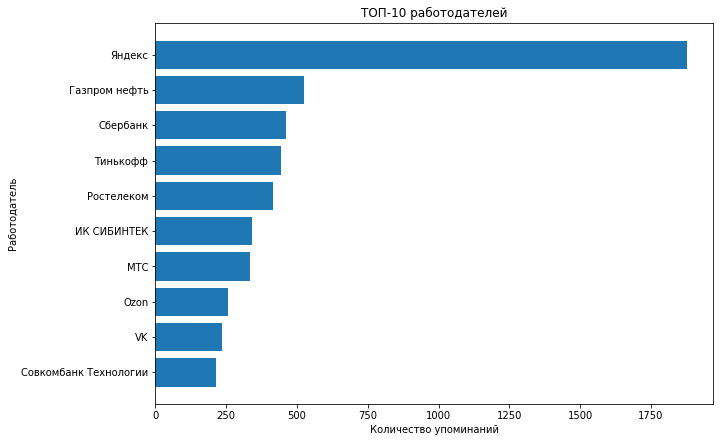

In [ ]:
plt.figure(figsize=(10,7))
plt.barh(top_employer_result.index, top_employer_result.values)
plt.title('ТОП-10 работодателей')
plt.xlabel('Количество упоминаний')
plt.ylabel('Работодатель')
plt.gca().invert_yaxis()
plt.show()

Выбор ключевыъ навыков:

In [ ]:
df['key_skills'][1]

"[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Тестирование'}, {'name': 'C#'}, {'name': 'API'}]"

In [ ]:
def skills(data):
  try:
    res = []
    for element in data:
      res.append(element['name'])
    return res
  except:
    return None

In [ ]:
df['key_skills_edited'] = df['key_skills'].fillna('{}').apply(eval).apply(skills)

In [ ]:
df['key_skills_edited']

0                                                       []
1                        [Git, SQL, Тестирование, C#, API]
2        [SQL, Linux, Информационная безопасность, Рабо...
3        [Пользователь ПК, Работа в команде, 1С: Предпр...
4        [MS Dos, Диагностика ПК, Компьютер, Работа в у...
                               ...                        
69651                                                   []
69652    [1С: Управление Торговлей, 1С: Предприятие 8, ...
69653    [Организаторские навыки, Работа в команде, Упр...
69654                                                   []
69655    [Информационная безопасность, Аудит безопаснос...
Name: key_skills_edited, Length: 49679, dtype: object

In [ ]:
new_df = df[['key_skills_edited', 'salary']] # датафрейм для анализа соотношения навыков и зарплат

In [ ]:
skill_salary = new_df.explode('key_skills_edited')
skill_salary

,key_skills_edited,salary
0,NaN,NaN
1,Git,33186.0
1,SQL,33186.0
1,Тестирование,33186.0
1,C#,33186.0
...,...,...
69655,Информационная безопасность,NaN
69655,Аудит безопасности,NaN
69655,Средства криптографической защиты информации,NaN
69655,Английский язык,NaN


In [ ]:
skill_salary['key_skills_edited'].value_counts().head(25)

SQL                            6268
Linux                          4855
Git                            4522
Английский язык                3905
Работа в команде               3438
Управление проектами           3404
Python                         3193
JavaScript                     2739
1С программирование            2567
PostgreSQL                     2514
Java                           2269
1С: Предприятие 8              2084
Грамотная речь                 2047
Аналитическое мышление         1906
Adobe Photoshop                1900
ООП                            1798
MS PowerPoint                  1754
MS SQL                         1727
MySQL                          1718
HTML                           1656
PHP                            1655
Информационные технологии      1618
Atlassian Jira                 1578
Docker                         1536
Информационная безопасность    1474
Name: key_skills_edited, dtype: int64

In [ ]:
skill_salary_top = skill_salary['key_skills_edited'].value_counts().head(25)

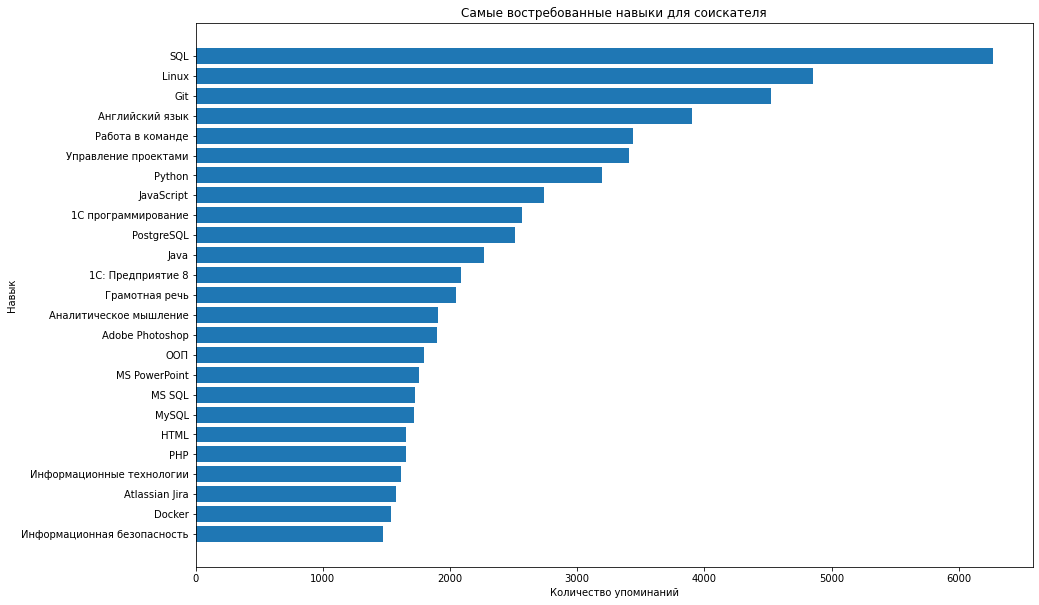

In [ ]:
plt.figure(figsize=(15,10))
plt.barh(skill_salary_top.index, skill_salary_top.values)
plt.title('Самые востребованные навыки для соискателя')
plt.xlabel('Количество упоминаний')
plt.ylabel('Навык')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
skills_df = pd.DataFrame(skill_salary.groupby('key_skills_edited')['salary'].mean().dropna()).reset_index()  # создаю новый датафрейм со средними значениями по скиллам
skills_df

,key_skills_edited,salary
0,"""СТЕК-РСО""",46720.000000
1,*nix системы,166666.666667
2,*nix-системы,140000.000000
3,- Опыт руководства отделом; - Навыки планирова...,41593.000000
4,.NET,142119.615385
...,...,...
7199,• умение работать в команде,112831.750000
7200,"• умение своевременно выявлять инциденты, связ...",75221.000000
7201,• умение читать чертежи;,80000.000000
7202,№223-фз,66372.000000


Пишу функцию фильтрации по ТОП-10 скиллам

In [ ]:
skill_salary_top_filter = list(skill_salary_top.index[:10])
skill_salary_top_filter

['SQL',
 'Linux',
 'Git',
 'Английский язык',
 'Работа в команде',
 'Управление проектами',
 'Python',
 'JavaScript',
 '1С программирование',
 'PostgreSQL']

In [ ]:
def return_top_skills(data):
  return data in skill_salary_top_filter

In [ ]:
filter2 = skills_df['key_skills_edited'].apply(return_top_skills)

Применяю фильтрацию, сбрасываю индекс и сортирую среднюю ЗП по уменьшению

In [ ]:
skill_salary_new = skills_df[filter2].reset_index().drop(['index'], axis=1).sort_values('salary', ascending=False)
skill_salary_new

,key_skills_edited,salary
4,PostgreSQL,166706.381198
5,Python,158718.823737
1,Git,153280.553104
2,JavaScript,133510.815201
7,Английский язык,130258.275727
6,SQL,128469.433709
3,Linux,119929.442438
9,Управление проектами,119305.071366
0,1С программирование,107584.678893
8,Работа в команде,73895.721159


Вывожу топ профессий по средней зарплате:

In [ ]:
df.groupby('name', as_index=False).agg({'salary': 'mean'}).sort_values('salary', ascending=False).head(20)

,name,salary
14988,Менеджер проекта Мобильное приложение,898230.0
8758,Брокер по продаже апартаментов,750000.0
8291,Архитектор облачных решений (Cloud Architects)...,750000.0
19709,СТО/Директор по разработке,750000.0
6371,Team lead / PHP (CTO),625000.0
17626,Разработчик Solidity/Разработчик Rust/Разработ...,600000.0
4390,Product manager LATOKEN,600000.0
738,BizDev Руководитель проекта (со знанием иврита),600000.0
906,"CTO / Global Head of Technology – Hamburg, Ger...",591000.0
4105,"Platform Engineering Manager - Java, Big Data ...",577035.0


# 7. Взаимосвязи данных

In [ ]:
df.groupby('name')['salary'].mean().sort_values(ascending=False).head(25)  # нахожу среднюю зарплату по названию вакансии

name
Менеджер проекта Мобильное приложение                                                 898230.0
Брокер по продаже апартаментов                                                        750000.0
Архитектор облачных решений (Cloud Architects), Германия                              750000.0
СТО/Директор по разработке                                                            750000.0
Team lead / PHP (CTO)                                                                 625000.0
Разработчик Solidity/Разработчик Rust/Разработчик Go/Разработчтик python(удаленно)    600000.0
Product manager LATOKEN                                                               600000.0
BizDev Руководитель проекта (со знанием иврита)                                       600000.0
CTO / Global Head of Technology – Hamburg, Germany                                    591000.0
Platform Engineering Manager - Java, Big Data (to Canada/Serbia)                      577035.0
1С:Эксперт по производительности 1С          

In [ ]:
df.reset_index(inplace=True)  # сбрасываю индекс датафрейма, чтобы определить индекс некорректного значения 'Брокер по продаже апартаментов'

In [ ]:
df.loc[(df['name'] == 'Брокер по продаже апартаментов')]

,index,id,name,salary,published_at,employer,experience,key_skills,region,key_skills_edited
39462,53889,53692636,Брокер по продаже апартаментов,750000.0,2022-05-06T10:41:41+0300,"{'id': '1625845', 'name': 'Агентство недвижимо...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Ведение переговоров'}, {'name': 'Те...",Краснодарский край,"[Ведение переговоров, Телефонные переговоры, Р..."


In [ ]:
df = df.drop(df.index[39462])  # удаляю некорректное значение

In [ ]:
mean_salary_by_name = df.groupby('name')['salary'].mean().sort_values(ascending=False).head(25)  # нахожу среднюю зарплату по названию вакансии

In [ ]:
mean_salary_by_name

name
Менеджер проекта Мобильное приложение                                                 898230.0
Архитектор облачных решений (Cloud Architects), Германия                              750000.0
СТО/Директор по разработке                                                            750000.0
Team lead / PHP (CTO)                                                                 625000.0
Product manager LATOKEN                                                               600000.0
Разработчик Solidity/Разработчик Rust/Разработчик Go/Разработчтик python(удаленно)    600000.0
BizDev Руководитель проекта (со знанием иврита)                                       600000.0
CTO / Global Head of Technology – Hamburg, Germany                                    591000.0
Platform Engineering Manager - Java, Big Data (to Canada/Serbia)                      577035.0
1С:Эксперт по производительности 1С                                                   575221.0
Web-дизайнер UI/UX                           

In [ ]:
mean_salary_by_name_df = pd.DataFrame(mean_salary_by_name)[:10]
mean_salary_by_name_df

,salary
name,
Менеджер проекта Мобильное приложение,898230.0
"Архитектор облачных решений (Cloud Architects), Германия",750000.0
СТО/Директор по разработке,750000.0
Team lead / PHP (CTO),625000.0
Product manager LATOKEN,600000.0
Разработчик Solidity/Разработчик Rust/Разработчик Go/Разработчтик python(удаленно),600000.0
BizDev Руководитель проекта (со знанием иврита),600000.0
"CTO / Global Head of Technology – Hamburg, Germany",591000.0
"Platform Engineering Manager - Java, Big Data (to Canada/Serbia)",577035.0


Такой вариант с максимальной среднее зарплатой не подойдёт, т.к. вакансии не входят в топ вакансий по всем данным. Определяю фильтр для датасета.

In [ ]:
job_to_analyse = list(job_title[:10].index)
job_to_analyse


['Системный администратор',
 'Программист 1C',
 'Специалист технической поддержки',
 'Системный аналитик',
 'Аналитик',
 'Инженер-программист',
 'Графический дизайнер',
 'Инженер технической поддержки',
 'Бизнес-аналитик',
 'Дизайнер']

In [ ]:
def return_salaries_for_top_jobs(data):
  return data in job_to_analyse

In [ ]:
df['name'].apply(return_salaries_for_top_jobs).describe()  # проверяю фильтр

count     49678
unique        2
top       False
freq      43977
Name: name, dtype: object

In [ ]:
filter = df['name'].apply(return_salaries_for_top_jobs)

In [ ]:
filtered_df = df[filter]

In [ ]:
filtered_df # здесь только ТОП-10 профессиий

,index,id,name,salary,published_at,employer,experience,key_skills,region,key_skills_edited
13,24,50473451,Бизнес-аналитик,NaN,2022-05-20T17:07:37+0300,"{'id': '115', 'name': 'Ай-Теко (I-Teco)', 'url...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Управление проектами'}, {'name': 'Б...",Астраханская область,"[Управление проектами, Бизнес-анализ, Системны..."
26,56,66075797,Системный администратор,50000.0,2022-05-25T12:15:23+0300,"{'id': '3025483', 'name': 'Лигал Кейс Компани'...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Ответственность и пунктуальность'},...",Астраханская область,"[Ответственность и пунктуальность, Администрир..."
27,57,55596717,Системный администратор,35398.0,2022-05-20T17:35:42+0300,"{'id': '4887922', 'name': 'Мединвестгрупп', 'u...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Настройка сетевых подключений'}, {'...",Астраханская область,"[Настройка сетевых подключений, Настройка ПК, ..."
28,58,54956000,Системный администратор,27434.0,2022-05-18T13:43:31+0300,"{'id': '3542521', 'name': 'ГБПОУ АО АГКПТ', 'u...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Настройка сетевых подключений'}, {'...",Астраханская область,"[Настройка сетевых подключений, Настройка ПО, ..."
32,62,54938836,Системный администратор,26548.0,2022-05-26T10:31:43+0300,"{'id': '2632291', 'name': 'АПК Астраханский', ...","{'id': 'noExperience', 'name': 'Нет опыта'}",[{'name': 'Администрирование сетевого оборудов...,Астраханская область,"[Администрирование сетевого оборудования, Наст..."
...,...,...,...,...,...,...,...,...,...,...
49661,69638,55583241,Программист 1C,NaN,2022-05-20T11:59:30+0300,"{'id': '51837', 'name': 'UCMS Group Russia', '...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': '1С: Предприятие 8'}, {'name': '1С п...",Тульская область,"[1С: Предприятие 8, 1С программирование, 1С: Б..."
49665,69642,55890279,Программист 1C,140000.0,2022-05-24T11:43:56+0300,"{'id': '5174849', 'name': 'Wanted', 'url': 'ht...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': '1С программирование'}, {'name': 'Ст...",Тульская область,"[1С программирование, Стремление к профессиона..."
49666,69643,55895723,Инженер-программист,44690.0,2022-05-24T13:37:01+0300,"{'id': '5711647', 'name': 'Бастион', 'url': 'h...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'оформление документации'}, {'name':...",Тульская область,"[оформление документации, 1C: Предприятие, Выс..."
49667,69644,55895724,Инженер-программист,44690.0,2022-05-24T13:37:01+0300,"{'id': '5711647', 'name': 'Бастион', 'url': 'h...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'оформление документации'}, {'name':...",Тульская область,"[оформление документации, 1C: Предприятие, Выс..."


In [ ]:
# filtered_df.groupby('name')['salary'].mean().sort_values(ascending=False)  # средняя зарплата по ТОП вакансиям

In [ ]:
# mean_salary_by_name10 = filtered_df.groupby('name')['salary'].mean().sort_values(ascending=False)

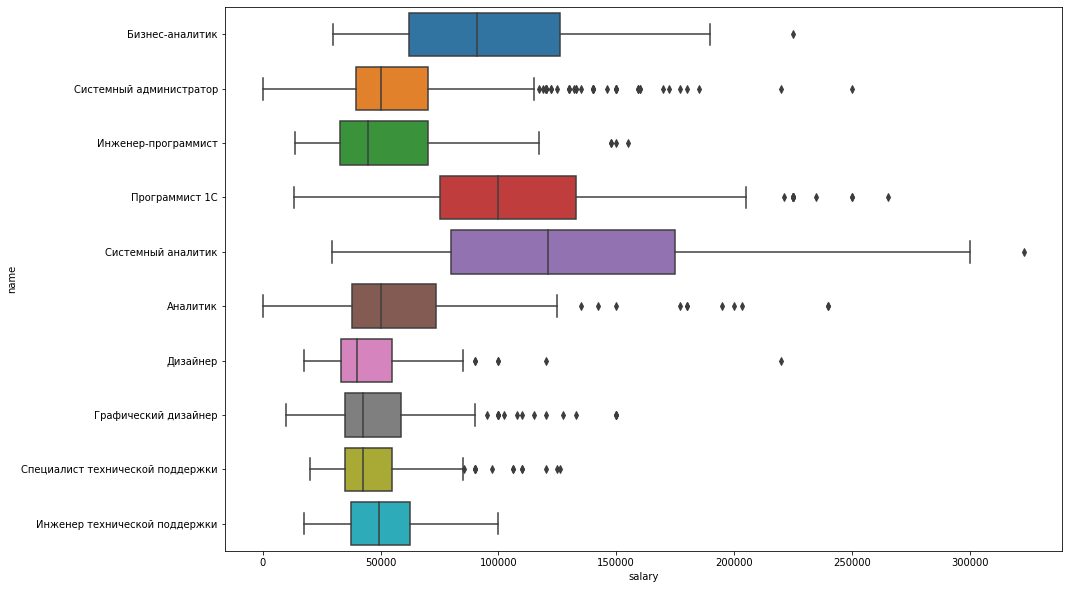

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(y='name', x='salary', data=filtered_df, orient="h")
plt.show()

Показываю взаимосвяь между ТОП навыками и средней зарплатой по ним.

In [ ]:
# sns.boxplot(y='key_skills_edited', x='salary', data=skills_df, orient="h")
# plt.show()

# 8. Выводы

__1. Топ вакансий__ в специализации ИТ приходится на следующие: Системный администратор, Программист 1C, Специалист технической поддержки, Системный аналитик, Аналитик, Инженер-программист, Графический дизайнер, Инженер технической поддержки, Бизнес-аналитик, Дизайнер.

__2. Топ работодателей:__ с явным отрывом на первом месте находится Яндекс. Далее следуют ведущие компании банковского, телекоммуникационного, нефтедобычи и ритейла: Газпром нефть, Сбербанк, Тинькофф, Ростелеком, ИК СИБИНТЕК, МТС,
Ozon, VK, Совкомбанк Технологии.

__3. Навыки:__ Самые востребованные навыки связаны с базами данных, операционной системой Linux, системой контроля версий Git и Английским языком, а так же Работа в команде.

__4. Топ по средней ЗП из ТОП навыков:__ PostgreSQL	166706
- Python	158718
- Git	153280
- JavaScript	133510
- Английский язык	130258

__5__. Самые большие зарплаты из ТОП вакансий у __Системных аналитиков, Бизнес-аналитиков и Программистов 1С__.

-----------------------------------------------------------------------------

---------------------------------------------------------------------------------

_Технический подвал для выгрузок результатов в файлы_

In [ ]:
df.head()

,index,id,name,salary,published_at,employer,experience,key_skills,region,key_skills_edited
0,0,49059633,Младший специалист ручного тестирования,NaN,2022-05-23T09:11:18+0300,"{'id': '1740', 'name': 'Яндекс', 'url': 'https...","{'id': 'noExperience', 'name': 'Нет опыта'}",[],Астраханская область,[]
1,1,54653519,Тестировщик.Net,33186.0,2022-04-28T17:36:03+0300,"{'id': '1245158', 'name': 'МФК Саммит', 'url':...","{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...",Астраханская область,"[Git, SQL, Тестирование, C#, API]"
2,2,55116066,Пентестер,NaN,2022-05-20T10:07:33+0300,"{'id': '719820', 'name': 'SearchInform', 'url'...","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...",Астраханская область,"[SQL, Linux, Информационная безопасность, Рабо..."
3,3,54031261,Ведущий Специалист по информационным технологиям,23008.0,2022-05-23T07:46:16+0300,"{'id': '4352', 'name': 'Почта России', 'url': ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Пользователь ПК'}, {'name': 'Работа...",Астраханская область,"[Пользователь ПК, Работа в команде, 1С: Предпр..."
4,4,55243040,Специалист по защите информации,20000.0,2022-05-06T10:18:54+0300,"{'id': '6694236', 'name': 'ГБПОУ АО Астраханск...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'MS Dos'}, {'name': 'Диагностика ПК'...",Астраханская область,"[MS Dos, Диагностика ПК, Компьютер, Работа в у..."


In [ ]:
df['employer'] = df['employer'].apply(employer)

In [ ]:
df.head()

,index,id,name,salary,published_at,employer,experience,key_skills,region,key_skills_edited
0,0,49059633,Младший специалист ручного тестирования,NaN,2022-05-23T09:11:18+0300,Яндекс,"{'id': 'noExperience', 'name': 'Нет опыта'}",[],Астраханская область,[]
1,1,54653519,Тестировщик.Net,33186.0,2022-04-28T17:36:03+0300,МФК Саммит,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...",Астраханская область,"[Git, SQL, Тестирование, C#, API]"
2,2,55116066,Пентестер,NaN,2022-05-20T10:07:33+0300,SearchInform,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...",Астраханская область,"[SQL, Linux, Информационная безопасность, Рабо..."
3,3,54031261,Ведущий Специалист по информационным технологиям,23008.0,2022-05-23T07:46:16+0300,Почта России,"{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Пользователь ПК'}, {'name': 'Работа...",Астраханская область,"[Пользователь ПК, Работа в команде, 1С: Предпр..."
4,4,55243040,Специалист по защите информации,20000.0,2022-05-06T10:18:54+0300,ГБПОУ АО Астраханский музыкальный колледж имен...,"{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'MS Dos'}, {'name': 'Диагностика ПК'...",Астраханская область,"[MS Dos, Диагностика ПК, Компьютер, Работа в у..."


In [ ]:
df.experience.unique()

array(["{'id': 'noExperience', 'name': 'Нет опыта'}",
       "{'id': 'between1And3', 'name': 'От 1 года до 3 лет'}",
       "{'id': 'between3And6', 'name': 'От 3 до 6 лет'}",
       "{'id': 'moreThan6', 'name': 'Более 6 лет'}"], dtype=object)

In [ ]:
df.experience.apply(eval)

0              {'id': 'noExperience', 'name': 'Нет опыта'}
1        {'id': 'between1And3', 'name': 'От 1 года до 3...
2          {'id': 'between3And6', 'name': 'От 3 до 6 лет'}
3              {'id': 'noExperience', 'name': 'Нет опыта'}
4              {'id': 'noExperience', 'name': 'Нет опыта'}
                               ...                        
49674      {'id': 'between3And6', 'name': 'От 3 до 6 лет'}
49675    {'id': 'between1And3', 'name': 'От 1 года до 3...
49676    {'id': 'between1And3', 'name': 'От 1 года до 3...
49677      {'id': 'between3And6', 'name': 'От 3 до 6 лет'}
49678           {'id': 'moreThan6', 'name': 'Более 6 лет'}
Name: experience, Length: 49678, dtype: object

In [ ]:
def experience_range(data):
  return json.loads(data.replace("'", '"'))['name']

In [ ]:
df.experience = df.experience.apply(experience_range)

In [ ]:
df.head()

,index,id,name,salary,published_at,employer,experience,key_skills,region,key_skills_edited
0,0,49059633,Младший специалист ручного тестирования,NaN,2022-05-23T09:11:18+0300,Яндекс,Нет опыта,[],Астраханская область,[]
1,1,54653519,Тестировщик.Net,33186.0,2022-04-28T17:36:03+0300,МФК Саммит,От 1 года до 3 лет,"[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...",Астраханская область,"[Git, SQL, Тестирование, C#, API]"
2,2,55116066,Пентестер,NaN,2022-05-20T10:07:33+0300,SearchInform,От 3 до 6 лет,"[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...",Астраханская область,"[SQL, Linux, Информационная безопасность, Рабо..."
3,3,54031261,Ведущий Специалист по информационным технологиям,23008.0,2022-05-23T07:46:16+0300,Почта России,Нет опыта,"[{'name': 'Пользователь ПК'}, {'name': 'Работа...",Астраханская область,"[Пользователь ПК, Работа в команде, 1С: Предпр..."
4,4,55243040,Специалист по защите информации,20000.0,2022-05-06T10:18:54+0300,ГБПОУ АО Астраханский музыкальный колледж имен...,Нет опыта,"[{'name': 'MS Dos'}, {'name': 'Диагностика ПК'...",Астраханская область,"[MS Dos, Диагностика ПК, Компьютер, Работа в у..."


In [ ]:
df = df.drop(['index', 'key_skills', 'published_at'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49678 entries, 0 to 49678
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 49678 non-null  int64  
 1   name               49678 non-null  object 
 2   salary             22477 non-null  float64
 3   employer           49613 non-null  object 
 4   experience         49678 non-null  object 
 5   region             49678 non-null  object 
 6   key_skills_edited  49678 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 3.0+ MB


In [ ]:
df.to_excel('eda.xlsx')

In [ ]:
skill_salary['key_skills_edited'].value_counts().to_excel('skill_salary.xlsx')

In [ ]:
skill_salary_new.to_excel('skill_salary_new.xlsx')

In [ ]:
skill_salary_new.reset_index(inplace=True)

In [ ]:
skill_salary_new.drop('index', axis=1)

,key_skills_edited,salary
0,PostgreSQL,166706.381198
1,Python,158718.823737
2,Git,153280.553104
3,JavaScript,133510.815201
4,Английский язык,130258.275727
5,SQL,128469.433709
6,Linux,119929.442438
7,Управление проектами,119305.071366
8,1С программирование,107584.678893
9,Работа в команде,73895.721159
